In [2]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()

In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

!kaggle competitions download -c santander-customer-transaction-prediction

 98% 244M/250M [00:01<00:00, 174MB/s]
100% 250M/250M [00:01<00:00, 143MB/s]


In [6]:
!unzip santander-customer-transaction-prediction

Archive:  santander-customer-transaction-prediction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               



## Load data and identify fake rows

In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [8]:
# Generate new features to check if each value is unique within each original
# column

col_names = [f'var_{i}' for i in range(200)]
for column in tqdm(col_names):
  c = test[column].value_counts()
  u = c.index[c == 1]
  test[column + '_u'] = test[column].isin(u)

100%|██████████| 200/200 [00:03<00:00, 50.92it/s]


In [9]:
# Add a column checking if at least one feature is unique for each row
test['unique'] = test[[column + '_u' for column in col_names]].any(axis=1)

In [10]:
# Separate out real test data and fake test data
test_real = test.loc[test.unique, ['ID_code'] + col_names]
test_fake = test.loc[~test.unique, ['ID_code'] + col_names]

In [11]:
# Combine all the 'real' data from the training and testing set so we can see if
# there are any fakes once they're combined

realTrTe = pd.concat([train, test_real], axis = 0)

In [12]:
# Generate another set of binary features to check if each value is unique 
# within each original feature column
for column in tqdm(col_names):
  c = realTrTe[column].value_counts()
  u = c.index[c == 1]
  realTrTe[column + '_unique'] = realTrTe[column].isin(u)*1
  test_fake[column + '_unique'] = 0

100%|██████████| 200/200 [00:08<00:00, 24.58it/s]


In [13]:
# From the combined set, isolate the real test values
test_real = realTrTe[realTrTe['ID_code'].str.contains('test')].copy()
test_real.drop(['target'], axis=1, inplace=True)

# Create a 'train' df with the new unique identifying features
# Create a 'test' df, combining the real and fake testing features
train = realTrTe[realTrTe['ID_code'].str.contains('train')].copy()
test = pd.concat([test_real, test_fake], axis=0)

In [17]:
# Split the training data into X and Y dataframes
X = train.iloc[:, 2:]
Y = train['target']

# Create the testing dataset for prediction
X_test = test.drop('ID_code', axis=1)

## Neural Network

In [32]:
model = Sequential()
model.add(Dense(25, input_dim=400, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(30, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(35, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(40, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(45, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

result = model.fit(X, Y, epochs = 100, batch_size = 300)

Epoch 1/100
667/667 [==============================] - 5s 5ms/step - loss: 0.3162 - binary_accuracy: 0.8988
Epoch 2/100
667/667 [==============================] - 4s 5ms/step - loss: 0.2786 - binary_accuracy: 0.8995
Epoch 3/100
667/667 [==============================] - 4s 5ms/step - loss: 0.2683 - binary_accuracy: 0.8995
Epoch 4/100
667/667 [==============================] - 4s 5ms/step - loss: 0.2638 - binary_accuracy: 0.9025
Epoch 5/100
667/667 [==============================] - 4s 5ms/step - loss: 0.2598 - binary_accuracy: 0.9034
Epoch 6/100
667/667 [==============================] - 4s 5ms/step - loss: 0.2576 - binary_accuracy: 0.9037
Epoch 7/100
667/667 [==============================] - 5s 7ms/step - loss: 0.2567 - binary_accuracy: 0.9048
Epoch 8/100
667/667 [==============================] - 4s 6ms/step - loss: 0.2558 - binary_accuracy: 0.9047
Epoch 9/100
667/667 [==============================] - 4s 5ms/step - loss: 0.2545 - binary_accuracy: 0.9059
Epoch 10/100
667/667 [======

In [33]:
y_pred = model.predict(X_test)

In [34]:
y_pred

array([[0.2967271 ],
       [0.35955676],
       [0.30522257],
       ...,
       [0.28561765],
       [0.05705563],
       [0.20149685]], dtype=float32)

In [35]:
submission = pd.DataFrame({"ID_code": test.iloc[:,0]})
submission["target"] = y_pred
submission.to_csv("submission.csv", index=False)

In [36]:
submission.head(10)

,ID_code,target
3,test_3,0.296727
7,test_7,0.359557
11,test_11,0.305223
15,test_15,0.179507
16,test_16,0.320603
17,test_17,0.174949
18,test_18,0.244391
20,test_20,0.251166
21,test_21,0.231034
22,test_22,0.154505


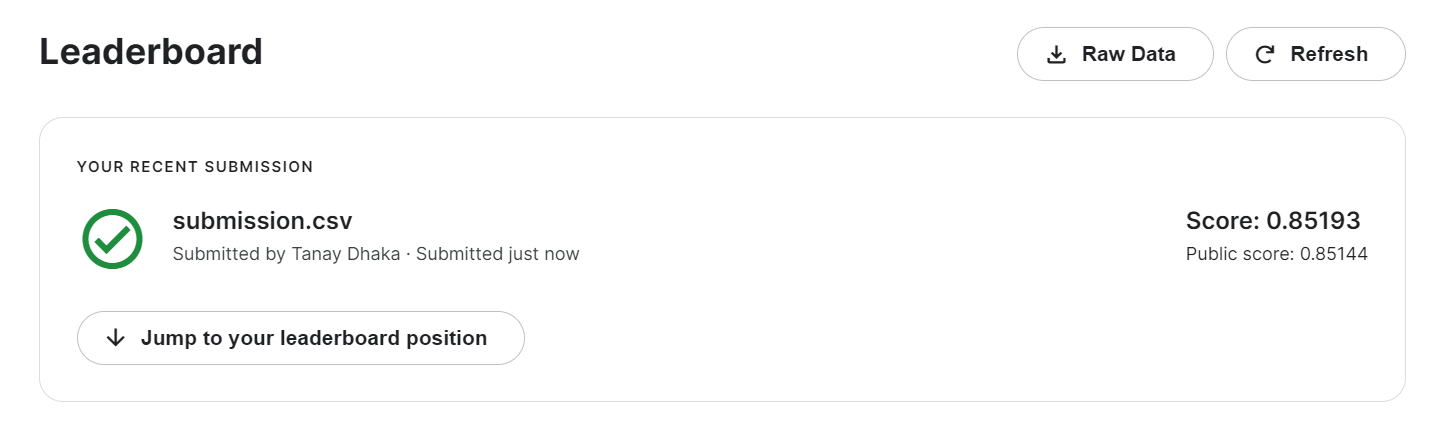